In [18]:
from debugpy.common.log import timestamp_format
from temporal_walk import TemporalWalk

from test import read_data

In [31]:
import numpy as np

def generate_temporal_graph_with_increasing_time(n_nodes, total_time, bias_strength=0):
    if bias_strength > 0:
        # Prioritize lower ordinal nodes (positive bias)
        base_probabilities = np.linspace(1, 1 - bias_strength, n_nodes)
    elif bias_strength < 0:
        # Prioritize higher ordinal nodes (negative bias)
        base_probabilities = np.linspace(-bias_strength, 1, n_nodes)
    else:
        # Uniform distribution (no bias)
        base_probabilities = np.ones(n_nodes)
    
    # Normalize the probabilities
    base_probabilities = base_probabilities / base_probabilities.sum()
    
    edges = []
    
    for current_timestamp in range(total_time):
        node_a = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)
        node_b = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)

        while node_a == node_b:
            node_b = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)

        edges.append((node_a, node_b, current_timestamp))
        
    return edges

In [32]:
edges = generate_temporal_graph_with_increasing_time(1000, 1_000_000)

In [33]:
NUM_WALKS = 100000
LEN_WALK = 50

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_time_vs_interaction_for_pickers(edges):
    picker_types = ["Uniform", "Linear", "Exponential"]
    MIN_TIMESTAMP = -9223372036854775808
    MAX_TIMESTAMP = 9223372036854775807
    
    results = {}
    time_results = {}
    node_visit_stats = {}
    timestamp_stats = {}
    
    for picker in picker_types:
        temporal_walk = TemporalWalk(NUM_WALKS, LEN_WALK, picker, None)
        temporal_walk.add_multiple_edges(edges)
        random_walks_with_times = temporal_walk.get_random_walks_with_times("Random")
        
        timestamp_frequencies = defaultdict(int)

        for walk in random_walks_with_times:
            for node, time in walk:
                if MIN_TIMESTAMP < time < MAX_TIMESTAMP:
                    timestamp_frequencies[time] += 1
        
        time_results[picker] = timestamp_frequencies
        
        timestamp_stats[picker] = {
            "mean": np.mean(list(timestamp_frequencies.values())),
            "std_dev": np.std(list(timestamp_frequencies.values()))
        }

    # Create the plot with additional statistical context
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot timestamp distributions with binned data
    for i, picker in enumerate(picker_types):
        times = list(time_results[picker].keys())
        counts = list(time_results[picker].values())
        
        axes[i].hist(times, bins=100, weights=counts, color='red', alpha=0.6)
        
        axes[i].set_title(f"Timestamp Frequencies ({picker} Picker)")
        axes[i].set_xlabel("Timestamp (binned)")
        axes[i].set_ylabel("Frequency")
        
        axes[i].text(0.05, 0.95, f"Mean: {timestamp_stats[picker]['mean']:.2f}",
                        transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    return fig

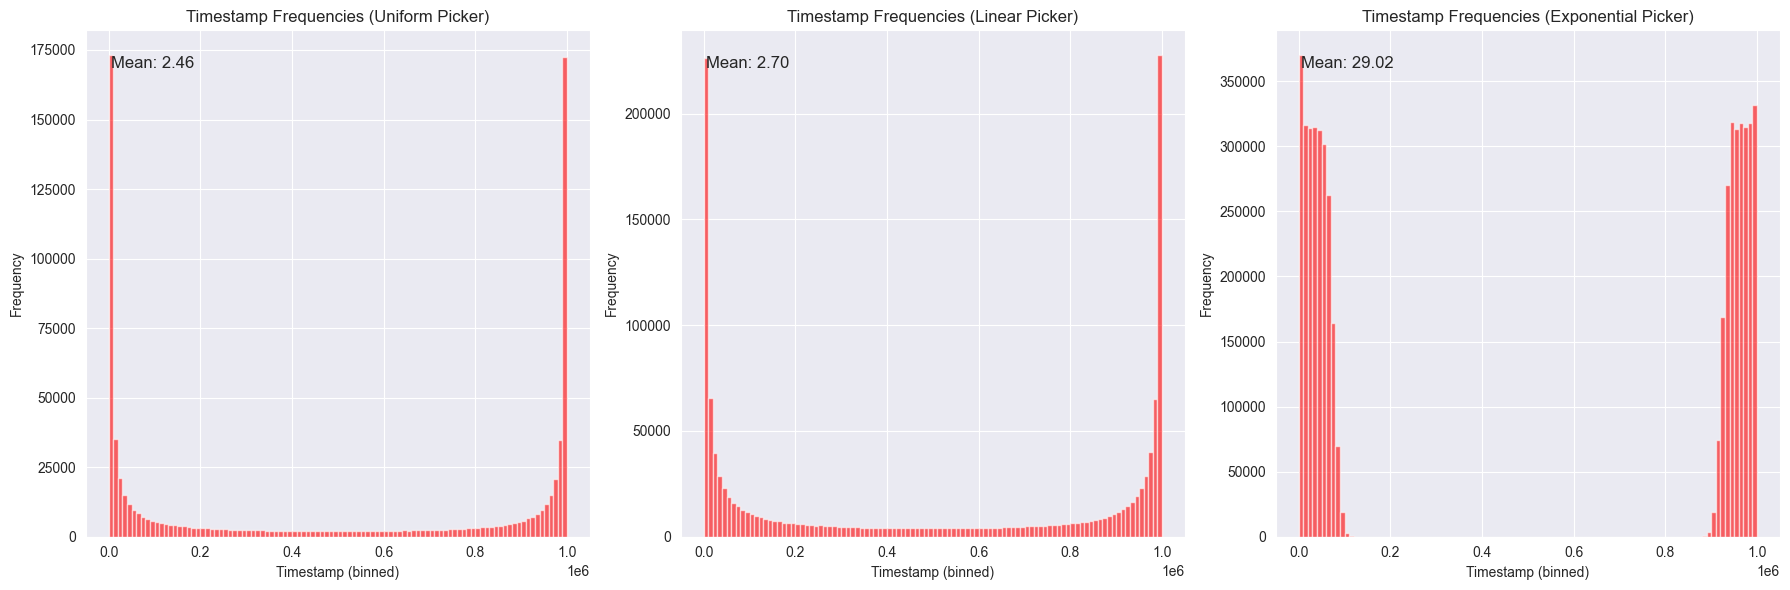

In [35]:
generate_time_vs_interaction_for_pickers(edges)
plt.savefig('plots/picker_comparison_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
edged_lower_order_prioritized = generate_temporal_graph_with_increasing_time(1000, 1_000_000, 0.8)

In [65]:
def plot_node_counts(edges):
    node_counts = defaultdict(int)
    
    for node_a, node_b, _ in edges:
        node_counts[node_a] += 1
        node_counts[node_b] += 1
    
    nodes = list(node_counts.keys())
    counts = list(node_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.hist(nodes, bins=100, weights=counts, color='red', alpha=0.6)
    
    plt.xlabel('Node ID')
    plt.ylabel('Number of Temporal Edges')
    plt.title('Node Counts of Temporal Edges')
    
    plt.tight_layout()
    plt.show()

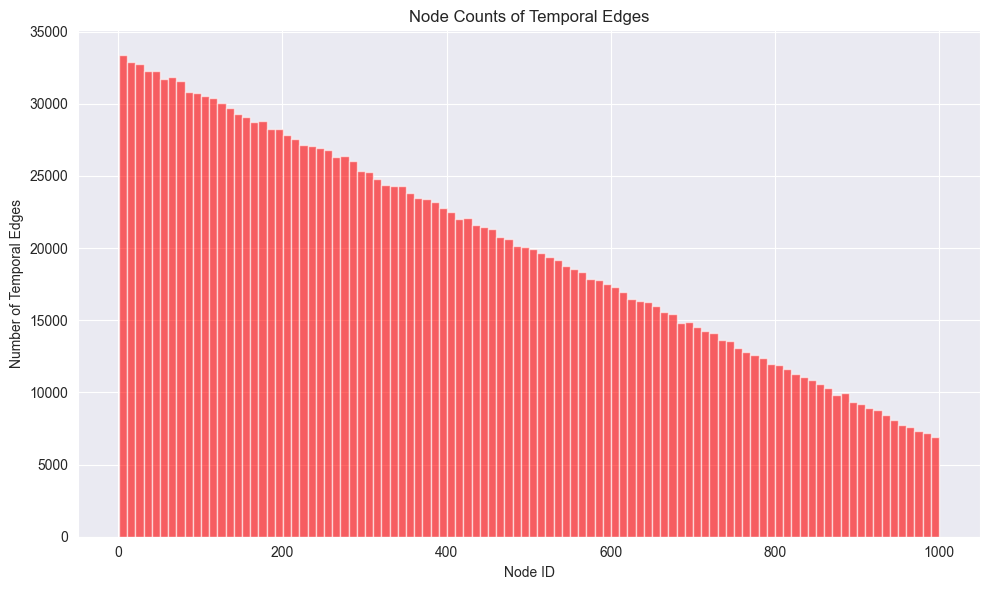

In [66]:
plot_node_counts(edged_lower_order_prioritized)

In [47]:
edged_higher_order_prioritized = generate_temporal_graph_with_increasing_time(1000, 1_000_000, -0.2)

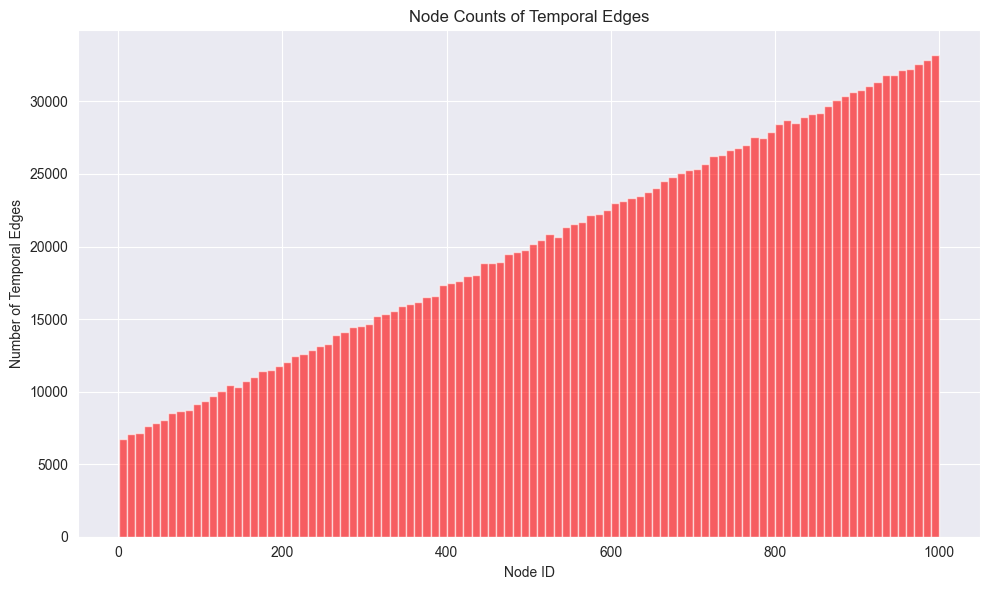

In [67]:
plot_node_counts(edged_higher_order_prioritized)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_node_vs_interaction_for_pickers(edges):
    picker_types = ["Uniform", "Linear", "Exponential"]
    
    node_results = {}
    node_visit_stats = {}
    
    for picker in picker_types:
        temporal_walk = TemporalWalk(NUM_WALKS, LEN_WALK, picker, None)
        temporal_walk.add_multiple_edges(edges)
        random_walks_with_times = temporal_walk.get_random_walks_with_times("Random")
        
        node_freqs = defaultdict(int)

        for walk in random_walks_with_times:
            for node, time in walk:
                node_freqs[node] += 1
        
        node_results[picker] = node_freqs
        
        node_visit_stats[picker] = {
            "mean": np.mean(list(node_freqs.values())),
            "std_dev": np.std(list(node_freqs.values()))
        }

    # Create the plot with additional statistical context
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot timestamp distributions with binned data
    for i, picker in enumerate(picker_types):
        nodes = list(node_results[picker].keys())
        counts = list(node_results[picker].values())
        
        axes[i].hist(nodes, bins=100, weights=counts, color='red', alpha=0.6)
        
        axes[i].set_title(f"Node Frequencies ({picker} Picker)")
        axes[i].set_xlabel("Node (binned)")
        axes[i].set_ylabel("Frequency")
        
        axes[i].text(0.05, 0.95, f"Mean: {node_visit_stats[picker]['mean']:.2f}",
                        transform=axes[i].transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    return fig

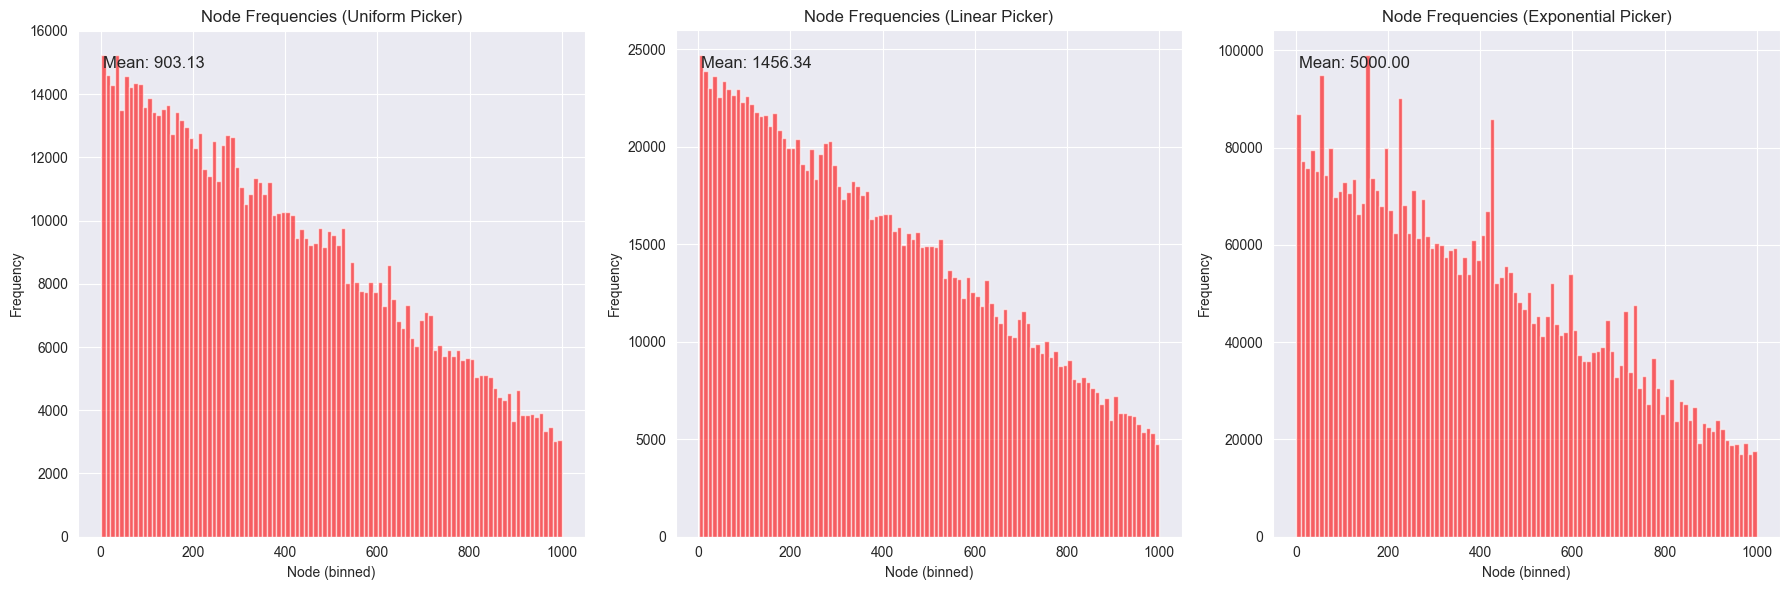

In [52]:
generate_node_vs_interaction_for_pickers(edged_lower_order_prioritized)
plt.show()

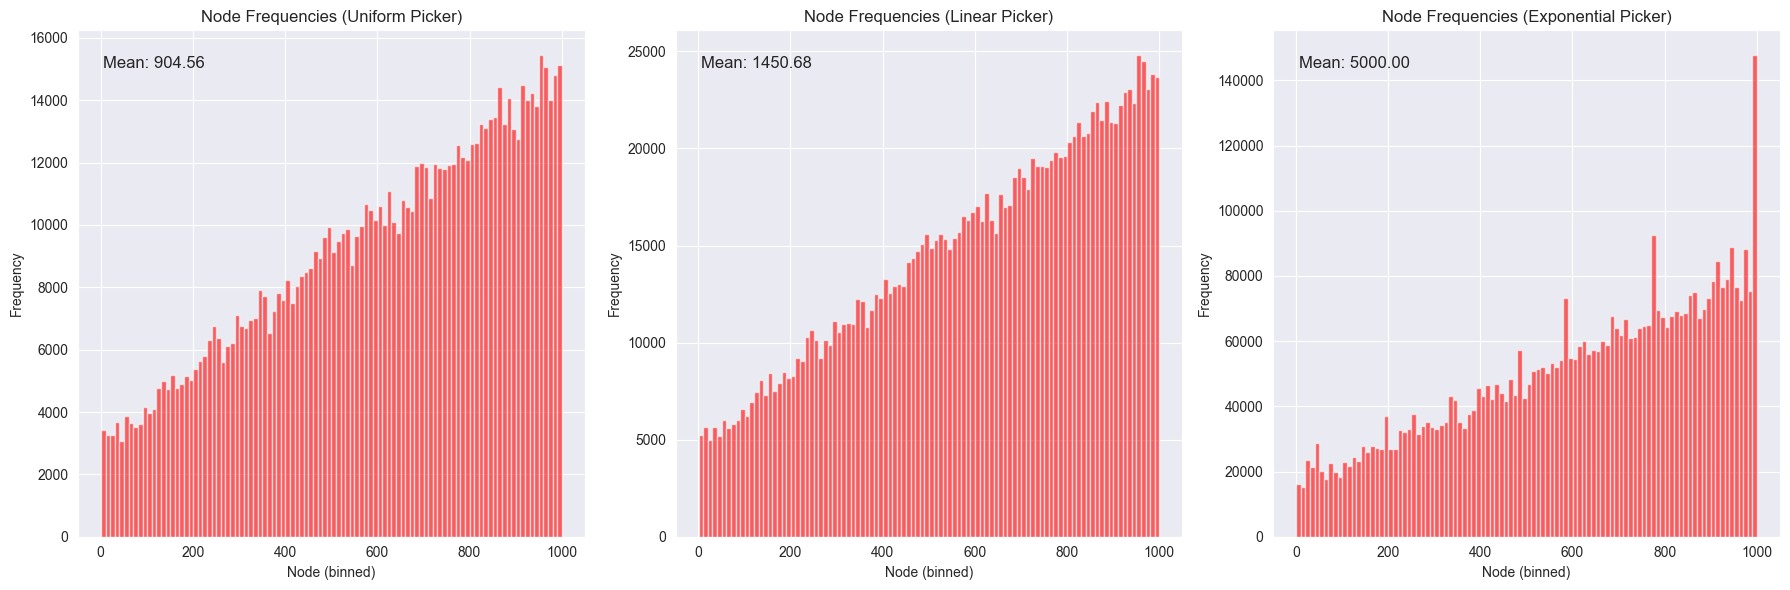

In [54]:
generate_node_vs_interaction_for_pickers(edged_higher_order_prioritized)
plt.show()

In [56]:
from test import read_data

alibaba_edges = read_data('alibaba')

In [61]:
def plot_node_and_time_distribution(edges):
    node_counts = defaultdict(int)
    timestamp_counts = defaultdict(int)
    
    for node_a, node_b, t in edges:
        node_counts[node_a] += 1
        node_counts[node_b] += 1
        timestamp_counts[t] += 1
    
    nodes = list(node_counts.keys())
    node_counts = list(node_counts.values())
    
    timestamps = sorted(list(timestamp_counts.keys()))
    timestamp_counts = [timestamp_counts[timestamp] for timestamp in timestamps]
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    axes[0].hist(nodes, bins=100, weights=node_counts, color='red', alpha=0.6)
    axes[0].set_xlabel('Node ID')
    axes[0].set_ylabel('Number of Temporal Edges')
    axes[0].set_title('Node Counts of Temporal Edges')
    
    axes[1].hist(timestamps, bins=100, weights=timestamp_counts, color='red', alpha=0.6)
    axes[1].set_xlabel('Timestamp')
    axes[1].set_ylabel('Number of Temporal Edges')
    axes[1].set_title('Timestamp Counts Temporal Edges')
    
    plt.tight_layout()
    return fig

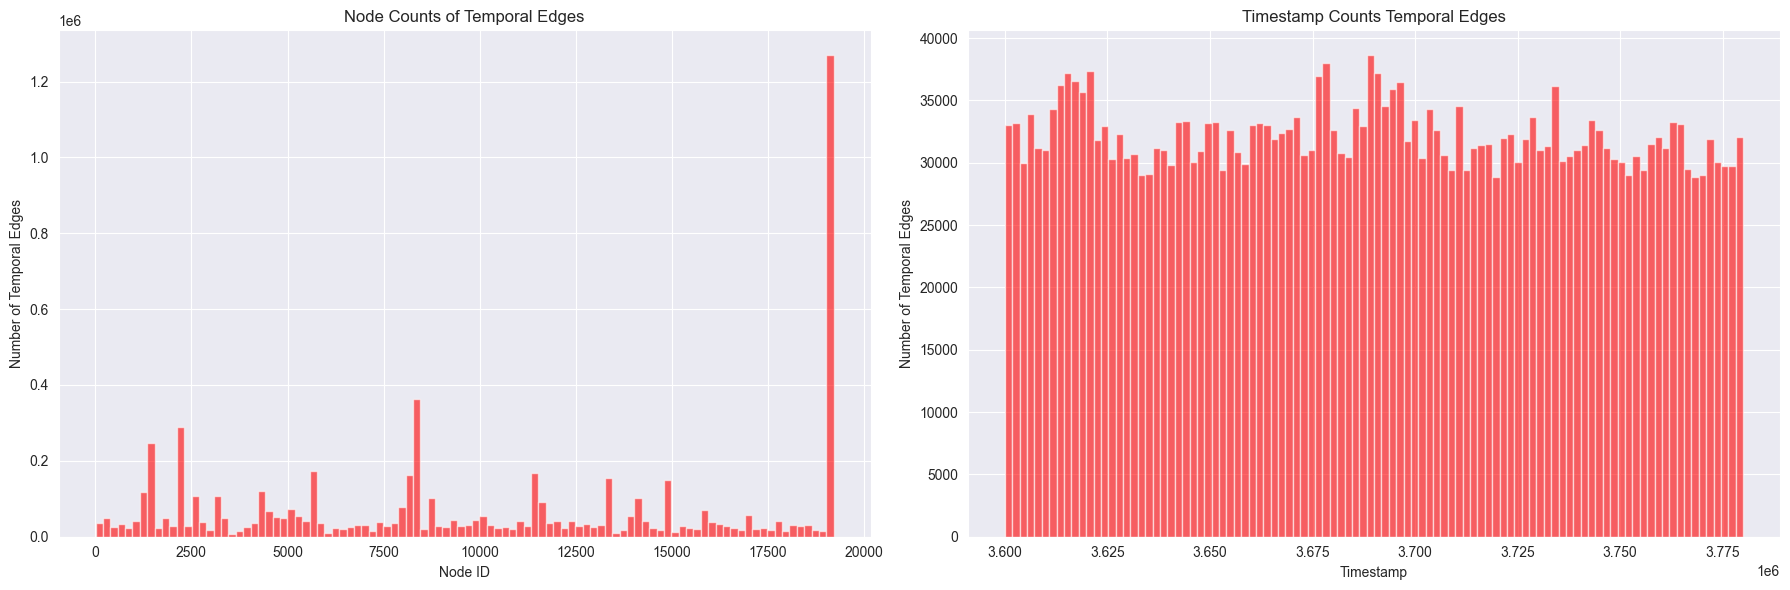

In [62]:
plot_node_and_time_distribution(alibaba_edges)
plt.show()

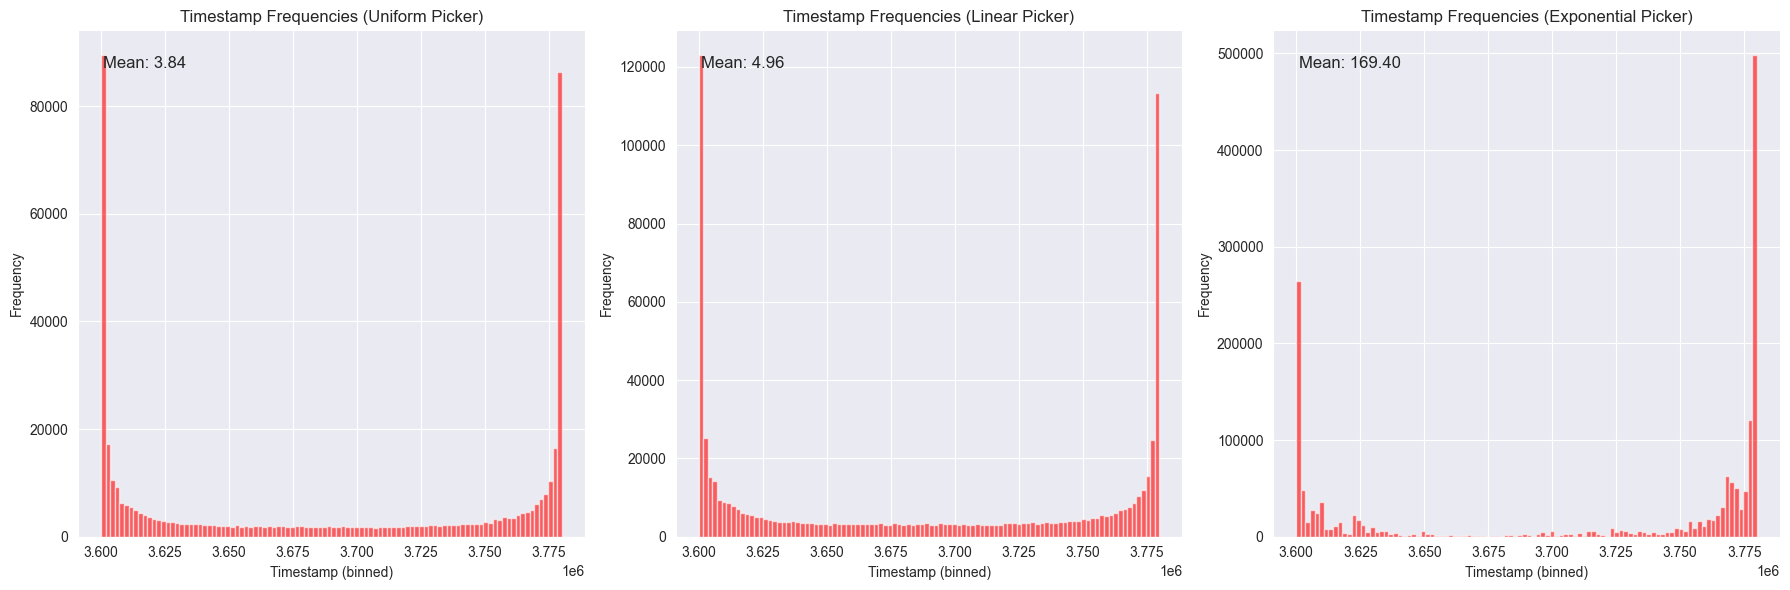

In [63]:
generate_time_vs_interaction_for_pickers(alibaba_edges)
plt.show()

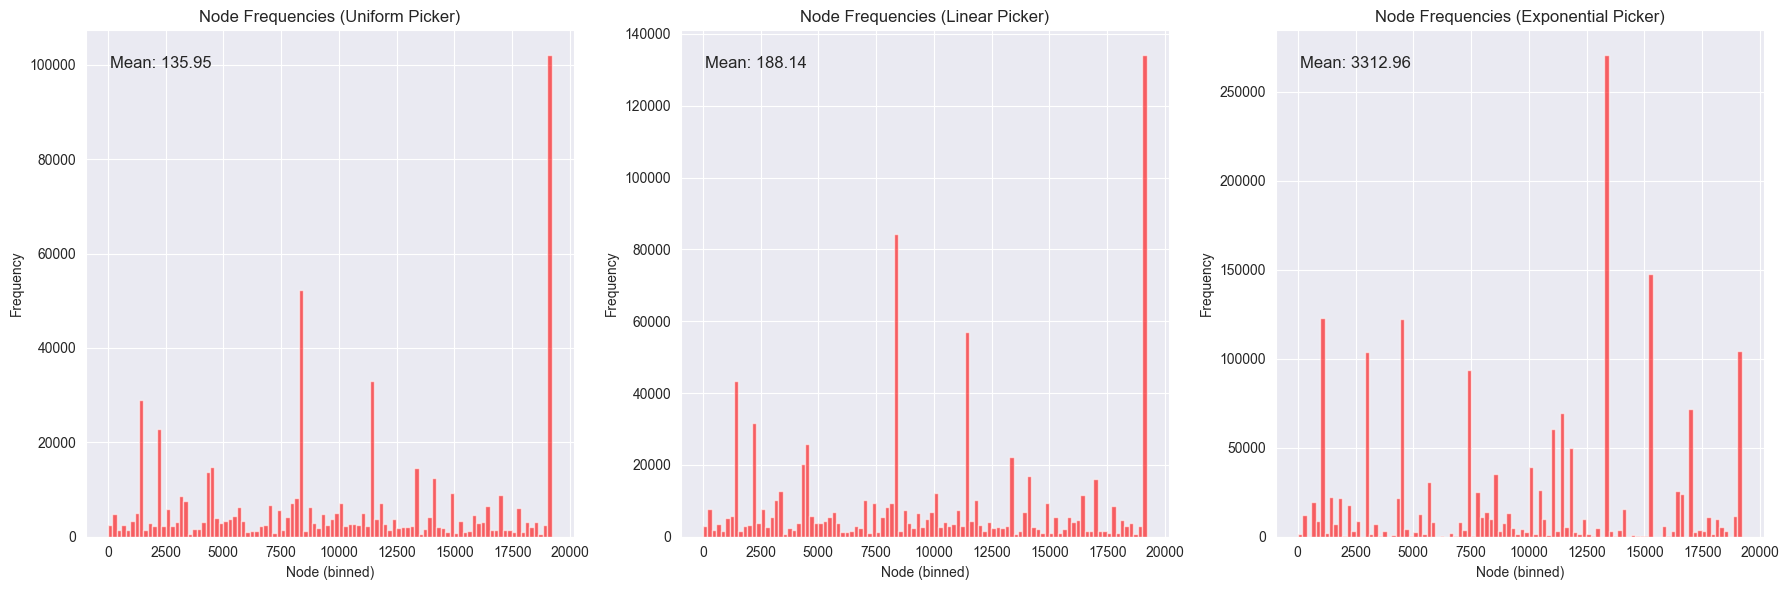

In [64]:
generate_node_vs_interaction_for_pickers(alibaba_edges)
plt.show()